In [7]:
# train
import wandb
from tqdm import tqdm
import torch
from torch import nn
from dataclasses import dataclass, asdict
import os
import sys
sys.path.append("/workspace/induction-head")
from data import SamplingLoader, IterDataset, SamplingDataset, MultiTaskSamplingLoader, IterDatasetFortask
from model import InputEmbedder, Transformer, TransformerICL, MultiTaskInputEmbedderV1, MultiTaskInputEmbedderV3
# from config_multi import TransformerConfig, TrainDataConfig, IWLDataConfig, ICLDataConfig, ICL2DataConfig, MainConfig
from configs.config_multi3 import TransformerConfig, TrainDataConfig, IWLDataConfig, ICLDataConfig, ICL2DataConfig, MainConfig
from argparse import ArgumentParser
from utils import visalize_attention
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
def cal_acc(t,p):
    p_arg = torch.argmax(p,dim=1)
    return torch.sum(t == p_arg) / p.shape[0]
def to_gpu_dict(dic, device="cuda:0"):
    dic = {k:v.to(device) if isinstance(v, torch.Tensor) else v for k,v in dic.items()}
    return dic


In [37]:
# モデルの指定されたレイヤーの出力と勾配を保存するクラス
class TaskVector:
    def __init__(self, model, target_layer):  # 引数：モデル, 対象のレイヤー
        self.model = model
        self.layer_output = []
        self.layer_grad = []
        
        # 特徴マップを取るためのregister_forward_hookを設定
        self.feature_handle = target_layer.register_forward_hook(self.feature)
        # 勾配を取るためのregister_forward_hookを設定
        self.grad_handle = target_layer.register_forward_hook(self.gradient)

    # self.feature_handleの定義時に呼び出されるメソッド
    ## モデルの指定されたレイヤーの出力（特徴マップ）を保存する
    def feature(self, model, input, output):
         activation = output
         self.layer_output.append(activation.to("cpu").detach())

    # self.grad_handleの定義時に呼び出されるメソッド
    ## モデルの指定されたレイヤーの勾配を保存する
    ## 勾配が存在しない場合や勾配が必要ない場合は処理をスキップ
    def gradient(self, model, input, output):
        # 勾配が無いとき
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            return # ここでメソッド終了

        # 勾配を取得
        def _hook(grad): 
            # gradが定義されていないが、勾配が計算されると各テンソルのgrad属性に保存されるっぽい（詳細未確認）
            self.layer_grad.append(grad.to("cpu").detach())

        # PyTorchのregister_hookメソッド（https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html）
        output.register_hook(_hook) 

    # メモリの解放を行うメソッド、フックを解除してメモリを解放する
    def release(self):
        self.feature_handle.remove()
        self.grad_handle.remove()

# モデルの指定されたレイヤーの出力と勾配を保存するクラス
class TaskVectorInjection:
    def __init__(self, model, target_layer, injection):  # 引数：モデル, 対象のレイヤー
        self.model = model
        self.target_layer = target_layer
        self.injection = injection
        
        self.feature_handle = target_layer.register_forward_hook(self.feature)
        
    
    def feature(self, model, input, output):
        output[:,-1] = self.injection[:,-1]
        return output
        


In [38]:
def main(config, save_dir):
    wandb.init(project="induction-head-task-vector", config=asdict(config))
    trainconfig = config.trainconfig
    modelconfig = config.modelconfig
    traindataconfig = config.traindataconfig
    icldataconfig = config.icldataconfig
    iwldataconfig = config.iwldataconfig
    icl2dataconfig = config.icl2dataconfig
    # data
    Dataset = SamplingDataset(traindataconfig)
    
    trainloader = MultiTaskSamplingLoader(traindataconfig, Dataset)
    train_seq_generator = trainloader.get_seq
    train_dataset = IterDataset(train_seq_generator)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=trainconfig.batch_size, pin_memory=True, num_workers=os.cpu_count())

    iclloader = MultiTaskSamplingLoader(icldataconfig, Dataset)
    icl_seq_generator = iclloader.get_seq
    icl_dataset = IterDataset(icl_seq_generator)
    icl_dataloader = torch.utils.data.DataLoader(icl_dataset, batch_size=trainconfig.batch_size, pin_memory=True, num_workers=os.cpu_count())

    iwlloader = MultiTaskSamplingLoader(iwldataconfig, Dataset)
    iwl_seq_generator = iwlloader.get_seq
    iwl_dataset = IterDataset(iwl_seq_generator)
    iwl_dataloader = torch.utils.data.DataLoader(iwl_dataset, batch_size=trainconfig.batch_size, \
        pin_memory=True, num_workers=os.cpu_count())
    
    # task_vector_loader = MultiTaskSamplingLoader(traindataconfig, Dataset)
    # task_vector_seq_generator = task_vector_loader.get_seq_for_task_vector
    # task_vector_dataset = IterDatasetFortask(task_vector_seq_generator)
    # task_vector_dataloader = torch.utils.data.DataLoader(task_vector_dataset, batch_size=trainconfig.batch_size, \
    #     pin_memory=True, num_workers=os.cpu_count())

    # icl2loader = MultiTaskSamplingLoader(icl2dataconfig, Dataset)
    # icl2_seq_generator = icl2loader.get_seq
    # icl2_dataset = IterDataset(icl2_seq_generator)
    # icl2_dataloader = torch.utils.data.DataLoader(icl2_dataset, batch_size=trainconfig.batch_size, pin_memory=True, num_workers=os.cpu_count())

    # model
    embedder = MultiTaskInputEmbedderV3(modelconfig)
    # if not modelconfig.use_standard_transformer:
    #     model = TransformerICL(embedder, modelconfig)
    # else:
    model = TransformerICL(embedder, modelconfig)
    model.to(config.device)

    # optimizer
    if trainconfig.optimizer == "adam":
        optimizer =  torch.optim.Adam(model.parameters(), lr=trainconfig.lr)
    elif trainconfig.optimizer == "adamw":
        optimizer =  torch.optim.AdamW(model.parameters(), lr=trainconfig.lr)
    elif trainconfig.optimizer == "sgd":
        optimizer =  torch.optim.SGD(model.parameters(), lr=trainconfig.lr)

    # loss
    criterion = nn.CrossEntropyLoss()
    step = 0
    for (data_dict, icl_data_dict, iwl_data_dict) in zip(tqdm(train_dataloader), icl_dataloader, iwl_dataloader):
        model.train()   
        data_dict = to_gpu_dict(data_dict, device=config.device)
        icl_data_dict = to_gpu_dict(icl_data_dict, device=config.device)
        iwl_data_dict = to_gpu_dict(iwl_data_dict , device=config.device)
        # icl2_data_dict = to_gpu_dict(icl2_data_dict , device=config.device)
        
        logits = model(data_dict["examples"], data_dict["labels"], data_dict["tasks"])
        query_logit = logits[:,-1,:]

        optimizer.zero_grad()
        
        loss = criterion(query_logit, data_dict["labels"][:, -1])
        loss.backward()
        optimizer.step()
        train_acc = cal_acc(data_dict["labels"][:, -1], query_logit)
        wandb.log({"train/acc":train_acc,"train/loss":loss}, step=step)
        
        if step % trainconfig.every_eval == 0:
            model.eval()
            with torch.no_grad():
                logits = model(icl_data_dict["examples"], icl_data_dict["labels"], icl_data_dict["tasks"])
                query_logit = logits[:,-1,:]
                icl_acc = cal_acc(icl_data_dict["labels"][:, -1], query_logit)
                wandb.log({"valid/icl_acc":icl_acc}, step=step)

                logits = model(iwl_data_dict["examples"], iwl_data_dict["labels"] , iwl_data_dict["tasks"])
                query_logit = logits[:,-1,:]
                iwl_acc = cal_acc(iwl_data_dict["labels"][:, -1], query_logit)
                wandb.log({"valid/iwl_acc":iwl_acc}, step=step)
                
                
                test_data_dict = iwl_data_dict["task_vector"]   
                test_data_dict = to_gpu_dict(test_data_dict, device=config.device)
                # embedder.Emb
                # atten_list
                # atten_list.0
                # atten_list.1
                # mlp_list
                # mlp_list.0
                # mlp_list.1
                # classifier
                emb = TaskVector(model, model.embedder.Emb)
                atten0 = TaskVector(model, model.atten_list[0])
                atten1 = TaskVector(model, model.atten_list[1])
                mlp0 = TaskVector(model, model.mlp_list[0])
                mlp1 = TaskVector(model, model.mlp_list[1])
                classifier = TaskVector(model, model.classifier)
                logits = model(test_data_dict["examples"], test_data_dict["labels"], test_data_dict["tasks"])
                query_logit = logits[:,-1,:]
                icl_acc = cal_acc(test_data_dict["labels"][:, -1], query_logit)
                wandb.log({"valid/test_icl_acc":icl_acc}, step=step)
                
                target_layer = model.atten_list[0]
                injection = atten0.layer_output[0]
                taskinjection = TaskVectorInjection(model, target_layer, injection)
                logits = model(iwl_data_dict["examples"], iwl_data_dict["labels"] , iwl_data_dict["tasks"])
                query_logit = logits[:,-1,:]
                icl_acc = cal_acc(iwl_data_dict["labels"][:, -1], query_logit)
                wandb.log({"valid/task_vector_icl_acc":icl_acc}, step=step)
                # logit : [batch, layer, seq_len, num_class]
                # logits = model.injection(task_hideen, iwl_data_dict["examples"], iwl_data_dict["labels"] , iwl_data_dict["tasks"])
                # logits = model(icl2_data_dict["examples"], icl2_data_dict["labels"], icl2_data_dict["task"])
                # query_logit = logits[:,-1,:]
                # icl2_acc = cal_acc(icl2_data_dict["labels"][:, -1, -1], query_logit)
                # wandb.log({"valid/icl2_acc":icl2_acc}, step=step)
                for layer_i in range(modelconfig.num_atten_layer):
                    attn_img = visalize_attention(model, layer_i)
                    wandb.log({"attention/layer_{}".format(layer_i):[wandb.Image(attn_img)]}, step=step)
                del attn_img, iwl_acc, icl_acc
                
        print("\r step:",step+1,"/",trainconfig.optimize_step, end="")
        step+=1
        if step > trainconfig.optimize_step:
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, config.exp_name+".pt"))
            break

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train/acc,▁
train/loss,▁
valid/icl_acc,▁
valid/iwl_acc,▁
valid/test_icl_acc,▁
train/acc,0.03125
train/loss,3.46732
valid/icl_acc,0.0
valid/iwl_acc,0.01562
valid/test_icl_acc,0.05469


0it [00:00, ?it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])


4it [00:04,  1.05it/s]

 step: 1 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 2 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 3 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 4 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 5 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 6 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 7 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])


15it [00:05,  5.88it/s]

 step: 8 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 9 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 10 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 11 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 12 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 13 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 14 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 15 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 16 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 17 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 18 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])


29it [00:05, 15.76it/s]

 step: 19 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 20 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 21 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 22 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 23 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 24 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 25 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 26 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 27 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 28 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 29 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 30 / 400000out

42it [00:05, 26.48it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 34 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 35 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 36 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 37 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 38 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 39 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 40 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 41 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 42 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 43 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 44 / 400000output torch.Size([12

55it [00:05, 38.67it/s]

 step: 45 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 46 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 47 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 48 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 49 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 50 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 51 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 52 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 53 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 54 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 55 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 56 / 400000out

69it [00:06, 48.63it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 59 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 60 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 61 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 62 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 63 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 64 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 65 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 66 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 67 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 68 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 69 / 400000output torch.Size([12

83it [00:06, 54.90it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 72 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 73 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 74 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 75 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 76 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 77 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 78 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 79 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 80 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 81 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 82 / 400000output torch.Size([12

91it [00:06, 59.68it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 85 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 86 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 87 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 88 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 89 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 90 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 91 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 92 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 93 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 94 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 95 / 400000output torch.Size([12

105it [00:06, 57.95it/s]

 step: 98 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 99 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 100 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 101 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 102 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 103 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 104 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 105 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 106 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 107 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])


118it [00:06, 56.20it/s]

 step: 108 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 109 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 110 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 111 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 112 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 113 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 114 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 115 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 116 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 117 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 118 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 119

132it [00:07, 60.13it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 121 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 122 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 123 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 124 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 125 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 126 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 127 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 128 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 129 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 130 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 131 / 400000output tor

146it [00:07, 62.78it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 134 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 135 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 136 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 137 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 138 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 139 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 140 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 141 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 142 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 143 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 144 / 400000output tor

153it [00:07, 63.32it/s]

 step: 147 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 148 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 149 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 150 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 151 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 152 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 153 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 154 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 155 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 156 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 157 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 158

168it [00:07, 61.33it/s]

 step: 161 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 162 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 163 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 164 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 165 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 166 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 167 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 168 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 169 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 170 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 171 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])


183it [00:07, 60.99it/s]

 step: 172 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 173 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 174 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 175 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 176 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 177 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 178 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 179 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 180 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 181 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 182 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 183

197it [00:08, 60.74it/s]

 step: 185 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 186 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 187 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 188 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 189 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 190 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 191 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 192 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 193 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 194 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 195 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 196

210it [00:08, 40.25it/s]

 step: 201 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 202 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 203 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 204 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 205 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 206 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 207 / 400000output torch.Si

222it [00:08, 46.02it/s]

 step: 213 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 214 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 215 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 216 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 217 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 218 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 219 / 400000output torch.Si

234it [00:09, 48.19it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 225 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 226 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 227 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 228 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 229 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 230 / 400000output torch.Size([128, 17, 128])


240it [00:09, 50.83it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 235 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 236 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 237 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 238 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 239 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 240 / 400000output torch.Size([128, 17, 128])


252it [00:09, 52.74it/s]

 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 247 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 248 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 249 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 250 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 251 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 252 / 400000output torch.Size([128, 17,

264it [00:09, 47.87it/s]

 step: 257 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 258 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 259 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 260 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 261 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 262 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 263 / 400000output torch.Si

275it [00:09, 48.92it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 266 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 267 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 268 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 269 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 270 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 271 / 400000output torch.Size([128, 17, 128])


281it [00:10, 50.15it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 276 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 277 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 278 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 279 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 280 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 281 / 400000output torch.Size([128, 17, 128])


293it [00:10, 54.01it/s]

 step: 287 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 288 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 289 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 290 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 291 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 292 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 293 / 400000output torch.Si

305it [00:10, 51.55it/s]

 step: 298 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 299 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 300 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 301 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 302 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 303 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 304 / 400000output torch.Si

317it [00:10, 52.28it/s]

 step: 309 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 310 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 311 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 312 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 313 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 314 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 315 / 400000output torch.Si

329it [00:10, 52.28it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 320 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 321 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 322 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 323 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 324 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 325 / 400000output torch.Size([128, 17, 128])


335it [00:11, 52.74it/s]

 step: 330 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 331 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 332 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 333 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 334 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 335 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 336 / 400000output torch.Si

347it [00:11, 51.97it/s]

 step: 341 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 342 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 343 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 344 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 345 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 346 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 347 / 400000output torch.Si

359it [00:11, 52.55it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 352 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 353 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 354 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 355 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 356 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 357 / 400000output torch.Size([128, 17, 128])


370it [00:11, 47.37it/s]

 step: 362 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 363 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 364 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 365 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 366 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 367 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 368 / 400000output torch.Si

375it [00:11, 46.69it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 371 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 372 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 373 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 374 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 375 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 376 / 400000output torch.Size([128, 17, 128])


386it [00:12, 48.75it/s]

 step: 380 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 381 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 382 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 383 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 384 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 385 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 386 / 400000output torch.Si

397it [00:12, 49.28it/s]

 torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 391 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 392 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 393 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 394 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 395 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 396 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
inject

408it [00:12, 32.90it/s]

 step: 401 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 402 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 403 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 404 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 405 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

419it [00:13, 38.49it/s]

 torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 412 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 413 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 414 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 415 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output 

430it [00:13, 43.62it/s]

 step: 421 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 422 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 423 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 424 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 425 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

435it [00:13, 44.70it/s]

 step: 431 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 432 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 433 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 434 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 435 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

446it [00:13, 45.44it/s]

 step: 441 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 442 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 443 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 444 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 445 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

456it [00:13, 41.24it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 450 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 451 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 452 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 453 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

461it [00:14, 40.64it/s]

 step: 457 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 458 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 459 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 460 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 461 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

472it [00:14, 44.35it/s]

 step: 466 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 467 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 468 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 469 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 470 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

482it [00:14, 45.45it/s]

 step: 476 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 477 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 478 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 479 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 480 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

492it [00:14, 44.53it/s]

 step: 486 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 487 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 488 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 489 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 490 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

503it [00:14, 46.47it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 496 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 497 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 498 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 499 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

513it [00:15, 45.41it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 505 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 506 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 507 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 508 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

523it [00:15, 47.04it/s]

 step: 514 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 515 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 516 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 517 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 518 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

533it [00:15, 46.52it/s]

 step: 524 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 525 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 526 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 527 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 528 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

538it [00:15, 44.24it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 534 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 535 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 536 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 537 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

548it [00:15, 43.08it/s]

 step: 542 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 543 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 544 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 545 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 546 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

558it [00:16, 41.65it/s]

 step: 551 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 552 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 553 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 554 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 555 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

563it [00:16, 41.45it/s]

 step: 559 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 560 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 561 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 562 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 563 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

573it [00:16, 44.20it/s]

 step: 568 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 569 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 570 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 571 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 572 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

583it [00:16, 44.86it/s]

 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 579 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 580 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 581 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 582 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17

593it [00:16, 44.70it/s]

 step: 587 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 588 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 589 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 590 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 591 / 400000output torch.Size([128, 17, 128])
injection torch.Siz

598it [00:17, 42.66it/s]

 torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 596 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 597 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 598 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 599 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output 

607it [00:17, 27.00it/s]

 step: 601 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 602 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 603 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 604 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

611it [00:17, 28.07it/s]

 step: 609 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 610 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 611 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 612 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

619it [00:17, 30.30it/s]

 step: 615 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 616 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 617 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 618 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

627it [00:18, 31.18it/s]

 step: 622 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 623 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 624 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 625 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

635it [00:18, 32.90it/s]

 step: 629 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 630 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 631 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 632 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

643it [00:18, 34.15it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 637 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 638 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 639 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

647it [00:18, 35.26it/s]


injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 644 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 645 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 646 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Siz

655it [00:19, 34.46it/s]

torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 651 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 652 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 653 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17,

663it [00:19, 33.82it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 658 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 659 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 660 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

667it [00:19, 33.62it/s]

 step: 664 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 665 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 666 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 667 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

675it [00:19, 35.12it/s]

 step: 671 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 672 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 673 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 674 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

683it [00:19, 33.15it/s]

 step: 678 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 679 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 680 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 681 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

691it [00:20, 33.34it/s]

 step: 685 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 686 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 687 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 688 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

699it [00:20, 34.50it/s]

 step: 692 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 693 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 694 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 695 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

703it [00:20, 34.46it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 700 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 701 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 702 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

711it [00:20, 35.98it/s]

 step: 707 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 708 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 709 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 710 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

719it [00:20, 35.97it/s]

 step: 715 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 716 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 717 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 718 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

727it [00:21, 35.28it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 723 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 724 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 725 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

735it [00:21, 34.87it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 730 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 731 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 732 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

743it [00:21, 34.92it/s]

 step: 736 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 737 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 738 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 739 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

747it [00:21, 32.98it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 744 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 745 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 746 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

755it [00:21, 31.59it/s]

 step: 749 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 750 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 751 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 752 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

759it [00:22, 32.61it/s]

 step: 756 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 757 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 758 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 759 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

767it [00:22, 33.25it/s]

 step: 763 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 764 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 765 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 766 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

775it [00:22, 34.37it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 771 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 772 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 773 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

783it [00:22, 33.80it/s]

 step: 778 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 779 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 780 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 781 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

791it [00:23, 34.04it/s]

 step: 785 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 786 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 787 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 788 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

799it [00:23, 34.48it/s]

 step: 792 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 793 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 794 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 795 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
o

806it [00:23, 21.07it/s]

 step: 801 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 802 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 803 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

809it [00:23, 22.18it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 807 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 808 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 809 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

817it [00:24, 26.19it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 813 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 814 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injec

821it [00:24, 27.74it/s]

 torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 819 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 820 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 821 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17

829it [00:24, 29.92it/s]

 step: 825 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 826 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 827 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

837it [00:24, 30.67it/s]

 step: 832 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 833 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 834 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

841it [00:24, 30.20it/s]

 step: 838 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 839 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 840 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

849it [00:25, 29.73it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 845 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 846 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injec

853it [00:25, 30.30it/s]

torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 851 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 852 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection to

861it [00:25, 30.59it/s]

 step: 857 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 858 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 859 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

868it [00:25, 27.89it/s]

torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 864 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 865 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection to

872it [00:25, 28.41it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 869 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 870 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 871 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

880it [00:26, 29.87it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 875 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 876 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 877 / 400000output torch.Size([1

884it [00:26, 30.23it/s]

 step: 881 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 882 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 883 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

892it [00:26, 30.51it/s]

 step: 887 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 888 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 889 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

896it [00:26, 30.31it/s]

 step: 894 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 895 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 896 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

904it [00:27, 29.57it/s]

 step: 900 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 901 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 902 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

911it [00:27, 29.45it/s]

 step: 906 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 907 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 908 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

918it [00:27, 29.94it/s]

 step: 912 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 913 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 914 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

921it [00:27, 29.71it/s]

injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 919 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 920 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 s

927it [00:27, 27.96it/s]

 step: 924 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 925 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 926 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

934it [00:28, 29.04it/s]

 step: 930 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 931 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 932 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

940it [00:28, 28.36it/s]

 step: 936 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 937 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 938 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

947it [00:28, 28.77it/s]

 step: 942 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 943 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 944 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

953it [00:28, 27.84it/s]

 step: 948 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 949 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 950 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

957it [00:28, 28.69it/s]

 step: 954 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 955 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 956 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

964it [00:29, 28.06it/s]

 step: 960 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 961 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 962 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

970it [00:29, 28.10it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 967 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 968 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injec

977it [00:29, 29.27it/s]

 step: 972 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 973 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 974 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

983it [00:29, 27.89it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 979 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 980 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injec

987it [00:29, 28.52it/s]

 step: 984 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 985 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 986 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

995it [00:30, 29.60it/s]

 torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 991 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 992 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection t

999it [00:30, 30.14it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 997 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 998 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 999 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([1

1006it [00:30, 19.90it/s]

 step: 1001 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1002 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1003 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1012it [00:31, 22.78it/s]

 step: 1007 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1008 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1009 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1018it [00:31, 24.55it/s]

 step: 1013 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1014 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1015 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1021it [00:31, 24.88it/s]

 step: 1019 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1020 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1021 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1027it [00:31, 24.44it/s]

 step: 1024 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1025 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1026 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1033it [00:31, 24.49it/s]

 step: 1029 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1030 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1031 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1039it [00:32, 25.44it/s]

 step: 1034 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1035 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1036 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1042it [00:32, 25.86it/s]

 torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1040 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1041 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1042 / 400000output torch.Size([128,

1048it [00:32, 26.65it/s]

 step: 1045 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1046 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1047 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1054it [00:32, 26.35it/s]

 step: 1051 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1052 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1053 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1060it [00:32, 26.92it/s]

 step: 1057 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1058 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1059 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1067it [00:33, 27.26it/s]

 step: 1063 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1064 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1065 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1073it [00:33, 27.39it/s]

 step: 1069 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1070 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1071 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1079it [00:33, 25.56it/s]

 step: 1075 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1076 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1077 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1085it [00:33, 25.63it/s]

 step: 1080 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1081 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1082 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1091it [00:34, 27.52it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1086 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1087 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
inj

1094it [00:34, 27.68it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1092 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1093 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
inj

1100it [00:34, 27.60it/s]

 step: 1097 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1098 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1099 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1106it [00:34, 27.43it/s]

 torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1103 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1104 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection

1112it [00:34, 27.17it/s]

 step: 1108 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1109 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1110 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1118it [00:35, 25.50it/s]

 torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1114 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1115 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1116 / 400000output torch.Size([128,

1121it [00:35, 25.38it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1119 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1120 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
inj

1127it [00:35, 25.67it/s]

 step: 1124 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1125 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1126 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1133it [00:35, 26.29it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1130 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1131 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
inj

1139it [00:35, 25.91it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1135 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1136 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
inj

1145it [00:36, 26.89it/s]

 step: 1140 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1141 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1142 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1151it [00:36, 25.93it/s]

 step: 1146 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1147 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1148 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1154it [00:36, 25.13it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1152 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1153 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
inj

1160it [00:36, 25.40it/s]

 step: 1156 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1157 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1158 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1166it [00:36, 24.86it/s]

torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1162 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1163 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection 

1169it [00:37, 25.94it/s]

output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1167 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1168 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
inj

1175it [00:37, 26.27it/s]

 step: 1172 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1173 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1174 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1181it [00:37, 26.10it/s]

 step: 1178 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1179 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
 step: 1180 / 400000output torch.Size([128, 17, 128])
injection torch.Size([128, 17, 128])
output torch.Size

1181it [00:38, 30.99it/s]


KeyboardInterrupt: 

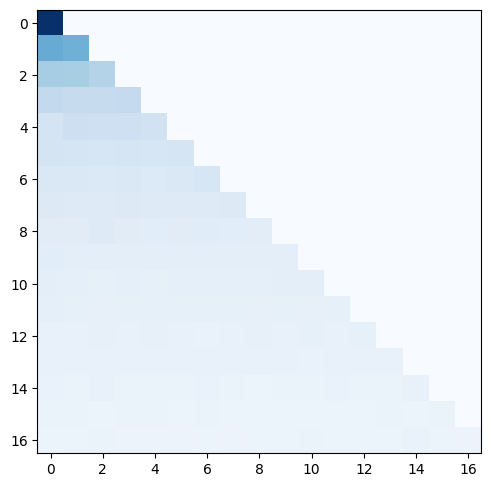

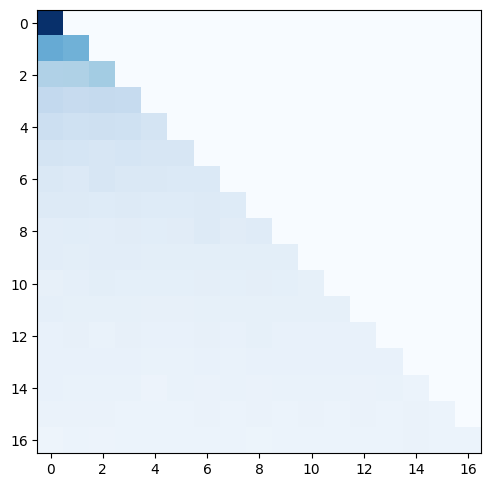

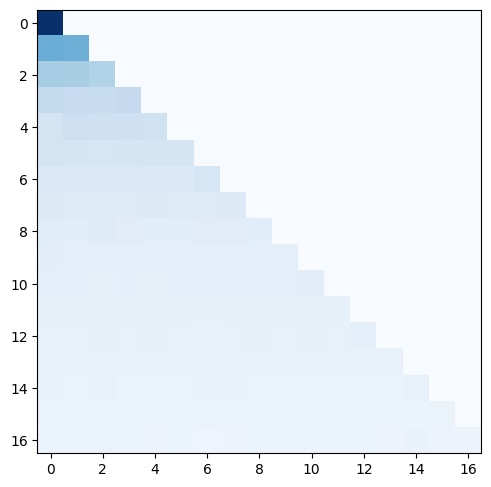

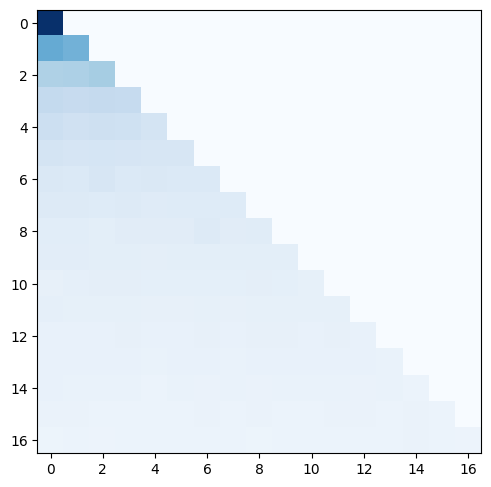

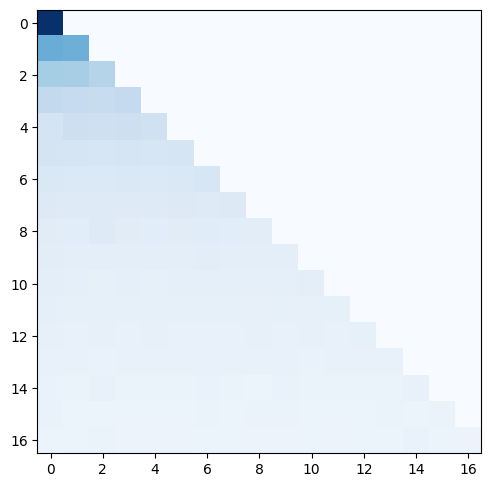

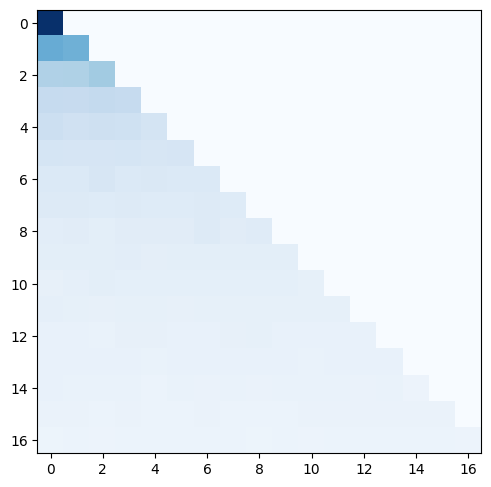

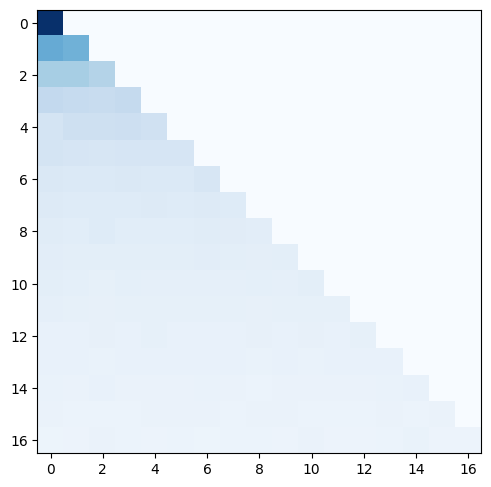

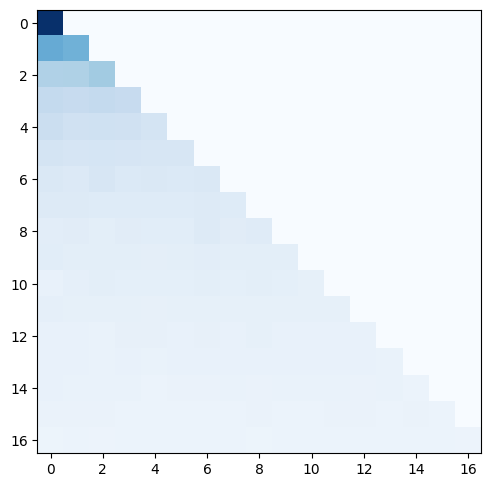

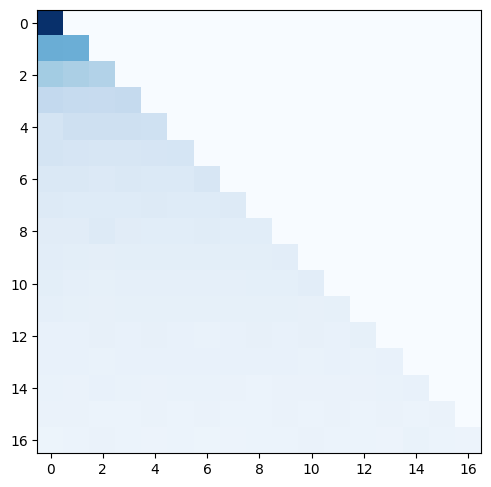

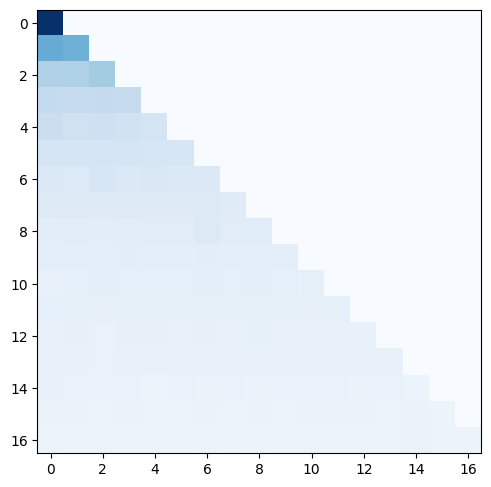

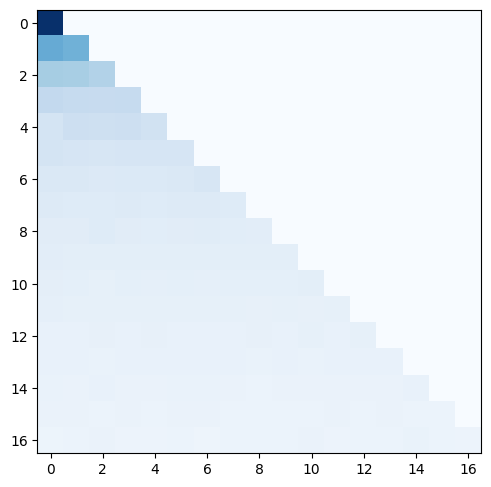

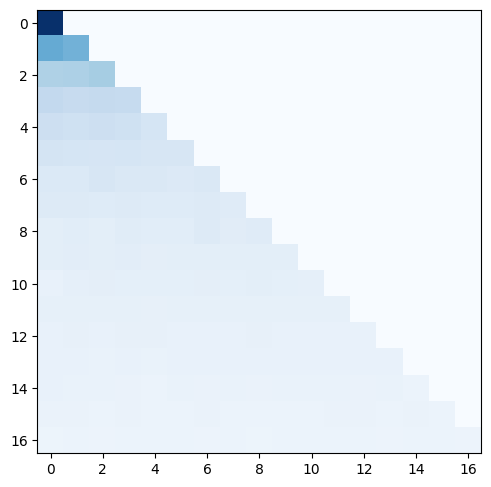

In [39]:
config = MainConfig()
main(config, "test")